In [1]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow import keras

from pathlib import Path
from realisticpipeml import read_data

In [2]:
#mode = 'Timelapse' # Use timelapse data for training and prediction
mode = 'Instant' # Use single acquisition for training and prediction
dynamic_nn = False # Automaticly scale network and encoding dim to size of input

sample_save = False # Save samples (only relevant to timelapse)
sample_load = True # Load samples (only relevant to timelapse)

autoencoder_save = False # Save the autoencoder
autoencoder_load = True # Load the autoencoder (to avoid rerunning)
#sensorindex = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Index of sensors to use
#sensorindex = [0, 3, 9, 12] # Index of sensors to use
#sensorindex = [0, 12]
sensorindex = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

timesamples = 640 # Number of time samples used in training. Fast time window length.

lastacq_only = True # Keep only last acquisition for training. Only relevant for Timelapse mode

In [5]:
#clock positions
mat = scipy.io.loadmat(Path().joinpath('..','data', 'input_simulated', 'trace_pos_clock_v7_rot_overlap.mat'))
X = mat['trace_pos_clock'].astype('float32')

In [18]:
# Fine sampling input
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_simulated', 'traces_fine_v7.mat'))
X = mat['traces'].astype('float32')
X = np.expand_dims(X, axis=0)
X = X[:,:,::6]

In [19]:
X.shape

(1, 750, 13)

In [20]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (1, 13, 750))

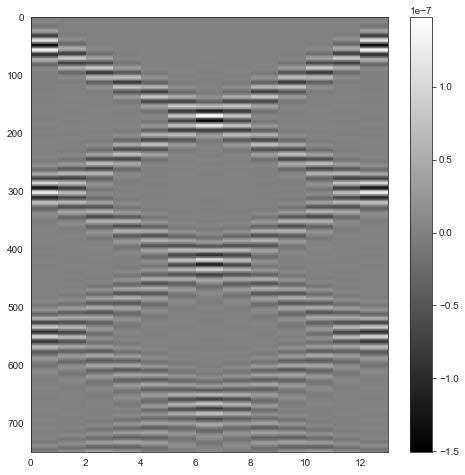

In [21]:
sns.set_style("white")
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [22]:
realdatapath = '../data/input_real/Waveforms_clock_pos/'

In [23]:
print(realdatapath)

../data/input_real/Waveforms_clock_pos/


In [24]:
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

20220210-01oc-040kHz.csv
20220210-01oc-041kHz.csv
20220210-01oc-042kHz.csv
20220210-01oc-043kHz.csv
20220210-01oc-044kHz.csv
20220210-01oc-045kHz.csv
20220210-01oc-046kHz.csv
20220210-01oc-047kHz.csv
20220210-01oc-048kHz.csv
20220210-01oc-049kHz.csv
20220210-01oc-050kHz.csv
20220210-01oc-051kHz.csv
20220210-01oc-052kHz.csv
20220210-01oc-053kHz.csv
20220210-01oc-054kHz.csv
20220210-01oc-055kHz.csv
20220210-01oc-056kHz.csv
20220210-01oc-057kHz.csv
20220210-01oc-058kHz.csv
20220210-01oc-059kHz.csv
20220210-01oc-060kHz.csv
20220210-01oc-061kHz.csv
20220210-01oc-062kHz.csv
20220210-01oc-063kHz.csv
20220210-01oc-064kHz.csv
20220210-01oc-065kHz.csv
20220210-01oc-066kHz.csv
20220210-01oc-067kHz.csv
20220210-01oc-068kHz.csv
20220210-01oc-069kHz.csv
20220210-01oc-070kHz.csv
20220210-01oc-071kHz.csv
20220210-01oc-072kHz.csv
20220210-01oc-073kHz.csv
20220210-01oc-074kHz.csv
20220210-01oc-075kHz.csv
20220210-01oc-076kHz.csv
20220210-01oc-077kHz.csv
20220210-01oc-078kHz.csv
20220210-01oc-079kHz.csv


In [25]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_simulated', 'labels_rot.csv'))

In [26]:
labels[labels['thickness'] == 34]

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var
560,model_t034_s101_d000_p002,34,101,0,2,1756.336829,278.267035,34,32,33.019387,33.0,0.726130,0.527265
561,model_t034_s101_d000_p004,34,101,0,4,1756.336829,278.267035,34,30,32.348958,32.0,1.172423,1.374575
562,model_t034_s101_d000_p006,34,101,0,6,1756.336829,278.267035,34,28,32.071759,32.0,1.447009,2.093836
563,model_t034_s101_d000_p008,34,101,0,8,1756.336829,278.267035,34,26,31.997975,32.0,1.554321,2.415915
564,model_t034_s101_d000_p010,34,101,0,10,1756.336829,278.267035,34,24,31.970775,32.0,1.612187,2.599146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,model_t034_s116_d024_p002,34,116,24,2,1512.291398,189.482963,34,8,29.716725,33.0,6.799712,46.236085
1116,model_t034_s116_d024_p004,34,116,24,4,1512.291398,189.482963,34,6,29.069734,32.0,6.841818,46.810476
1117,model_t034_s116_d024_p006,34,116,24,6,1512.291398,189.482963,34,5,28.725116,31.0,6.901768,47.634402
1118,model_t034_s116_d024_p008,34,116,24,8,1512.291398,189.482963,34,5,28.568866,31.0,6.943093,48.206544


In [27]:
X.shape

(1, 13, 750)

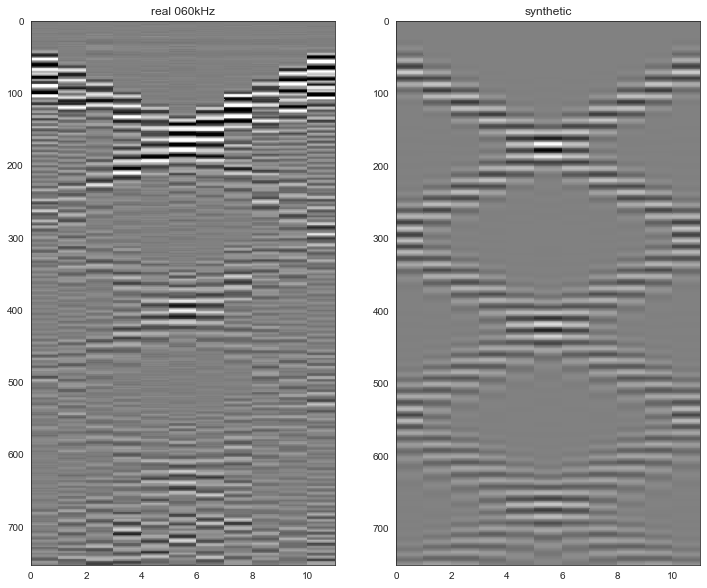

In [30]:
freq = '060kHz'
sns.set_style("white")
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.pcolor(df_waveforms[freq].to_numpy()[900:4660:5,:-1], cmap='gray')
plt.gca().invert_yaxis()
plt.title('real ' + str(freq))
#plt.colorbar()
plt.clim(-0.2, 0.2)
plt.subplot(1,2,2)

plt.pcolor(X[0,1:12,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('synthetic')

plt.show()